# Plot marginals

In [1]:
# Import packages
import torch
import numpy as np
from scipy import stats

import larsflow as lf

import boltzgen as bg
import mdtraj

from matplotlib import pyplot as plt
import matplotlib as mpl

from tqdm import tqdm
from time import time

In [2]:
# Specify checkpoint root
#checkpoint_root = ['/draco/u/vstimper/projects/resampled-base-flows/experiments/bg/rnvp/fkld/gauss_03/', 
#                   '/draco/u/vstimper/projects/resampled-base-flows/experiments/bg/rnvp/fkld/gauss_15/',
#                   '/draco/u/vstimper/projects/resampled-base-flows/experiments/bg/rnvp/fkld/resampled_03/']
checkpoint_root = ['/draco/u/vstimper/projects/resampled-base-flows/experiments/bg/resflow/fkld/gauss_02/',
                   '/draco/u/vstimper/projects/resampled-base-flows/experiments/bg/resflow/fkld/resampled_05/']

In [3]:
# Load config
config = [lf.utils.get_config(cpr + 'config/config.yaml') for cpr in checkpoint_root]

In [4]:
# Load data
test_data = torch.load('/draco/u/vstimper/projects/resampled-base-flows/datasets/boltzmann-generators/aldp_test_transformed.pt')

In [5]:
# Setup model
model = [lf.BoltzmannGenerator(conf) for conf in config]
n_models = len(model)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = [m.to(device) for m in model]
model = [m.eval() for m in model]

# Remove target distribution
for i in range(n_models):
    model[i].p = None

# Load checkpoint
for m, cpr in zip(model, checkpoint_root):
    m.load(cpr + 'checkpoints/model_0500000.pt')

In [6]:
# Set params for transform
ndim = 66
z_matrix = [
    (0, [1, 4, 6]),
    (1, [4, 6, 8]),
    (2, [1, 4, 0]),
    (3, [1, 4, 0]),
    (4, [6, 8, 14]),
    (5, [4, 6, 8]),
    (7, [6, 8, 4]),
    (11, [10, 8, 6]),
    (12, [10, 8, 11]),
    (13, [10, 8, 11]),
    (15, [14, 8, 16]),
    (16, [14, 8, 6]),
    (17, [16, 14, 15]),
    (18, [16, 14, 8]),
    (19, [18, 16, 14]),
    (20, [18, 16, 19]),
    (21, [18, 16, 19])
]
cart_indices = [6, 8, 9, 10, 14]

# Load data for transform
# Load the alanine dipeptide trajectory
traj = mdtraj.load('/draco/u/vstimper/projects/resampled-base-flows/datasets/boltzmann-generators/aldp_train.h5')
traj.center_coordinates()

# superpose on the backbone
ind = traj.top.select("backbone")

traj.superpose(traj, 0, atom_indices=ind, ref_atom_indices=ind)

# Gather the training data into a pytorch Tensor with the right shape
training_data = traj.xyz
n_atoms = training_data.shape[1]
n_dim = n_atoms * 3
training_data_npy = training_data.reshape(-1, n_dim)
training_data = torch.from_numpy(training_data_npy.astype("float64"))

# Set up transform
transform = bg.flows.CoordinateTransform(training_data, ndim,
                                         z_matrix, cart_indices)

In [7]:
# Draw samples
n_samples = 1000
n_batches = 1000

t = np.zeros((len(model), n_batches))
z_np = np.zeros((len(model), n_batches * n_samples, 60))
x_np = np.zeros((len(model), n_batches * n_samples, 66))

for i in range(len(model)):
    for j in tqdm(range(n_batches)):
        st = time()
        z, _ = model[i].sample(n_samples)
        t[i, j] = time() - st
        x, _ = transform(z.cpu().double())
        x_np[i, (j * n_samples):((j + 1) * n_samples), :] = x.data.numpy()
        z, _ = transform.inverse(x)
        z_np[i, (j * n_samples):((j + 1) * n_samples), :] = z.data.numpy()

100%|██████████| 1000/1000 [19:58<00:00,  1.20s/it]


In [8]:
# Test data to np
z_d_np = test_data.cpu().data.numpy()

## Dihedral angles

In [10]:
# Estimate density
nbins = 100
hist_range = [-np.pi, np.pi]

ncarts = transform.mixed_transform.len_cart_inds
z_d_np_ = np.concatenate([z_d_np[:, :(3 * ncarts - 6)], np.zeros((z_d_np.shape[0], 6)),
                          z_d_np[:, (3 * ncarts - 6):]], axis=1)
z_np_ = np.concatenate([z_np[:, :, :(3 * ncarts - 6)], np.zeros((n_models, z_np.shape[1], 6)),
                        z_np[:, :, (3 * ncarts - 6):]], axis=2)
dih_ind = transform.mixed_transform.ic_transform.dih_indices.numpy()
std_dih = transform.mixed_transform.ic_transform.std_dih.numpy()
permute_inv = transform.mixed_transform.permute_inv.numpy()
z_d_np_ = z_d_np_[:, permute_inv]
z_np_ = z_np_[:, :, permute_inv]
z_d_np_[:, dih_ind] *= std_dih
z_np_[:, :, dih_ind] *= std_dih

ndims = z_np.shape[2]

hists_test = np.zeros((nbins, ndim ))
hists_gen = np.zeros((n_models, nbins, ndim))

for i in tqdm(range(ndims)):
    htest, _ = np.histogram(z_d_np_[:, i], nbins, range=hist_range, density=True);
    hists_test[:, i] = htest
    
    for j in range(n_models):
        hgen, _ = np.histogram(z_np_[j, :, i], nbins, range=hist_range, density=True);
        hists_gen[j, :, i] = hgen

100%|██████████| 60/60 [00:02<00:00, 26.12it/s]


In [11]:
# Split histograms into groups
ncarts = transform.mixed_transform.len_cart_inds
permute_inv = transform.mixed_transform.permute_inv
bond_ind = transform.mixed_transform.ic_transform.bond_indices
angle_ind = transform.mixed_transform.ic_transform.angle_indices
dih_ind = transform.mixed_transform.ic_transform.dih_indices

hists_test_cart = hists_test[:, :(3 * ncarts - 6)]
hists_test_bond = hists_test[:, bond_ind]
hists_test_angle = hists_test[:, angle_ind]
hists_test_dih = hists_test[:, dih_ind]

hists_gen_cart = hists_gen[:, :, :(3 * ncarts - 6)]
hists_gen_bond = hists_gen[:, :, bond_ind]
hists_gen_angle = hists_gen[:, :, angle_ind]
hists_gen_dih = hists_gen[:, :, dih_ind]

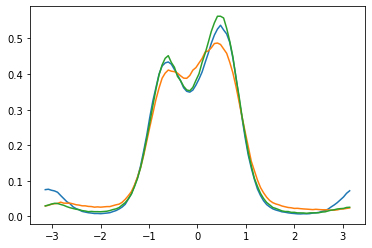

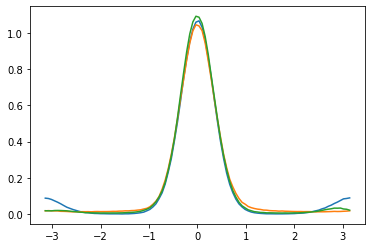

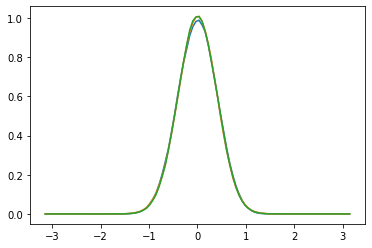

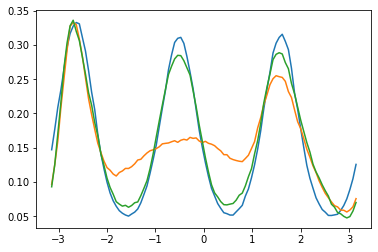

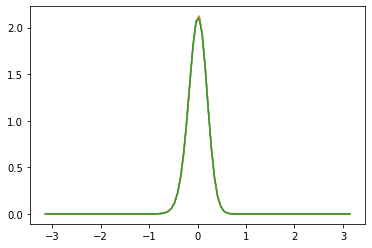

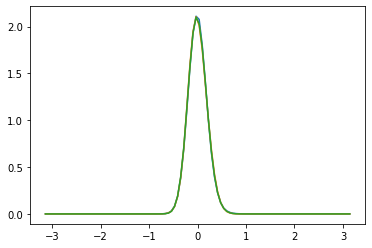

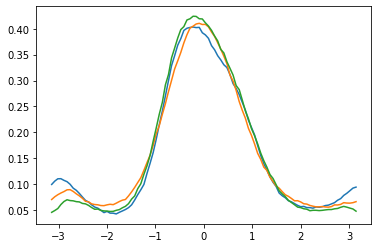

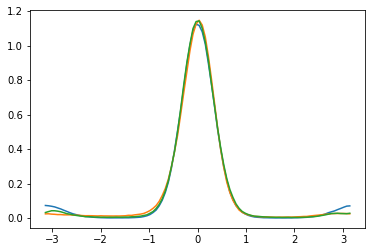

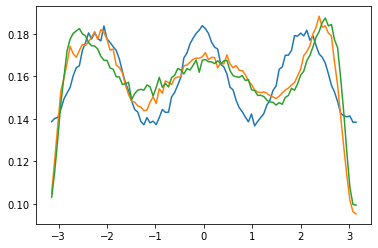

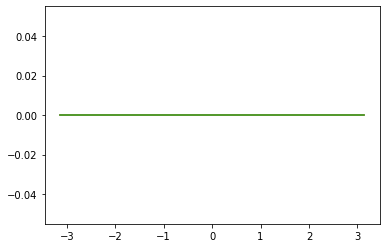

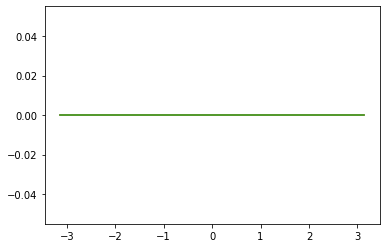

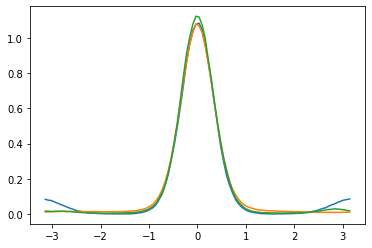

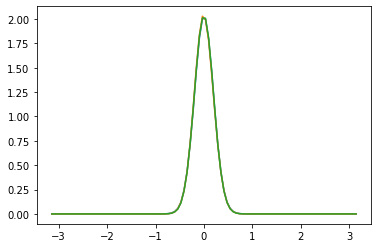

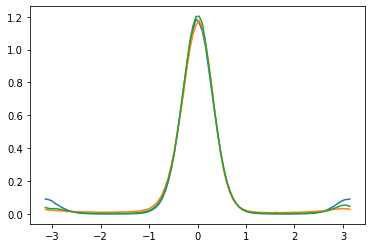

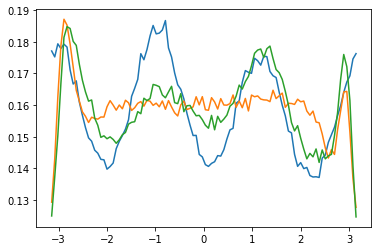

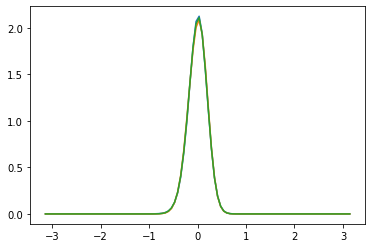

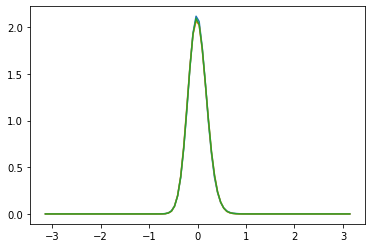

In [12]:
x = np.linspace(*hist_range, nbins)

for i in range(hists_test_dih.shape[1]):
    plt.plot(x, hists_test_dih[:, i])
    for j in range(n_models):
        plt.plot(x, hists_gen_dih[j, :, i])
    plt.show()

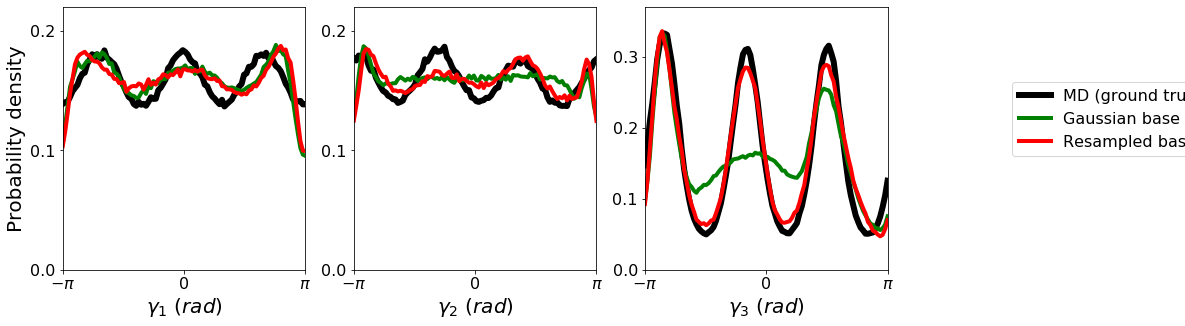

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[3].set_axis_off()
ind = [8, 14, 3]
color = ['k', 'g', 'r', 'r'] #['k', 'g', 'r']
ymax = [0.22, 0.22, 0.37]
l = []
ax[0].set_ylabel('Probability density', fontsize=20)
for i in range(3):
    l_, = ax[i].plot(x, hists_test_dih[:, ind[i]], color[0], linewidth=6)
    l = l + [l_]
    ax[i].set_ylim([0, ymax[i]])
    ax[i].set_xticks([-np.pi, 0, np.pi])
    ax[i].set_yticks([0, .1, .2] if i < 2 else [0, .1, .2, .3])
    ax[i].set_xticklabels(['$-\pi$', '0', '$\pi$'])
    ax[i].tick_params(axis='x', which='both', labelsize=16)
    ax[i].tick_params(axis='y', which='both', labelsize=16)
    ax[i].set_xlabel('$\gamma_%i\,\, (rad)$' % (i + 1), fontsize=20)
    ax[i].set_xlim([-np.pi, np.pi])
    for j in range(n_models):
        l_, = ax[i].plot(x, hists_gen_dih[j, :, ind[i]], color[j + 1], linewidth=4)
        l = l + [l_]
#fig.legend(l, ['MD (ground truth)', 'Gaussian base\n16 layers', 'Gaussian base\n19 layers', 'Resampled base\n16 layers'],
#           fontsize=16, bbox_to_anchor=(0.85, 0.8))
fig.legend(l, ['MD (ground truth)', 'Gaussian base', 'Resampled base'],
           fontsize=16, bbox_to_anchor=(0.85, 0.7))
fig.subplots_adjust(bottom=0.15)
plt.savefig('/draco/u/vstimper/projects/resampled-base-flows/plots/dihedrals/resflow_fkld.png', dpi=300)

## Ramachandran plot

In [33]:
x_d_np = np.zeros((0, 66))

# Determine likelihood of test data
for i in range(int(np.floor((len(test_data) - 1) / n_samples))):
    z = test_data[(i * n_samples):((i + 1) * n_samples), :]
    x, _ = transform(z.cpu().double())
    x_d_np = np.concatenate((x_d_np, x.data.numpy()))
z = test_data[((i + 1) * n_samples):, :]
x, _ = transform(z.cpu().double())
x_d_np = np.concatenate((x_d_np, x.data.numpy()))

In [34]:
# Compute Ramachandran plot angles
test_traj = mdtraj.Trajectory(x_d_np.reshape(-1, 22, 3), traj.top)
psi_d = mdtraj.compute_psi(test_traj)[1].reshape(-1)
psi_d[np.isnan(psi_d)] = 0
phi_d = mdtraj.compute_phi(test_traj)[1].reshape(-1)
phi_d[np.isnan(phi_d)] = 0

# Compute KLD of Ramachandran plot angles
nbins_ram = 64
eps_ram = 1e-10
hist_ram_test = np.histogram2d(phi_d, psi_d, nbins_ram,
                               range=[[-np.pi, np.pi], [-np.pi, np.pi]])[0]

In [38]:
# Ramachandran plot
plt.figure(figsize=(10, 10))
plt.hist2d(phi_d, psi_d, bins=64, norm=mpl.colors.LogNorm())
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$\phi$', fontsize=24)
plt.ylabel('$\psi$', fontsize=24)
plt.savefig('/draco/u/vstimper/projects/resampled-base-flows/plots/ramachandran/test_data.png', dpi=300)
plt.close()